# 필수 라이브러리 설치

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import random

# Hyperparameters

In [ ]:
#Hyperparameters
learning_rate = 5*1e-5
gamma         = 0.99
buffer_limit  = 10000
batch_size    = 32

# Grid World

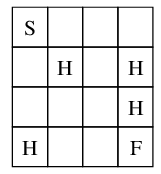

In [ ]:
# model 설정
# 4x4, state는 (x, y), H:hole, G:goal
# reward: goal:1 이며 나머지는 0
#
#     0  1  2  3
#     4  H  6  H
#     8  9 10  H
#     H 12 13  G
#
class GridWorld():
    def __init__(self):
        self.x = 0
        self.y = 0

    def step(self, a):
        # 0번 액션: 왼쪽, 1번 액션: 위, 2번 액션: 오른쪽, 3번 액션: 아래쪽
        if a == 0:
            self.move_left()
        elif a == 1:
            self.move_down()
        elif a == 2:
            self.move_right()
        elif a == 3:
            self.move_up()

        if self.x == 3 and self.y == 3:
            reward = 1
        else:
            reward = 0

        done = self.is_done()
        return (self.x, self.y), reward, done

    def move_down(self):
        self.y += 1
        if self.y > 3:
            self.y = 3

    def move_up(self):
        self.y -= 1
        if self.y < 0:
            self.y = 0

    def move_left(self):
        self.x -= 1
        if self.x < 0:
            self.x = 0

    def move_right(self):
        self.x += 1
        if self.x > 3:
            self.x = 3

    def is_done(self):
        if self.x == 3 and self.y == 3:
            return True
        elif self.x == 0 and self.y == 3:
            return True
        elif self.x == 1 and self.y == 1:
            return True
        elif self.x == 3 and self.y == 1:
            return True
        elif self.x == 3 and self.y == 2:
            return True
        else:
            return False

    def get_state(self):
        return (self.x, self.y)

    def reset(self):
        # Random Initialize

        start = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (2, 1), (2, 0), (2, 1), (2, 2), (3, 1), (3, 2)]
        (self.x,self.y)=random.choice(start)
        return (self.x, self.y)

# Replay Buffer

In [ ]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

# Network

In [ ]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, s, epsilon):
        out = self.forward(s)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 3)
        else:
            return out.argmax().item()

    def max_action(self, s):
        out = self.forward(s)
        return out.argmax().item()

# Train

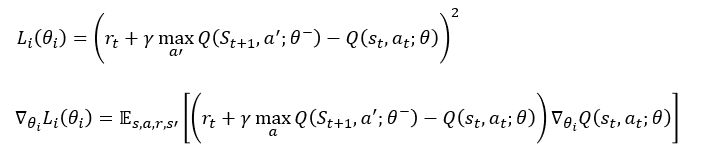

In [ ]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# DQN

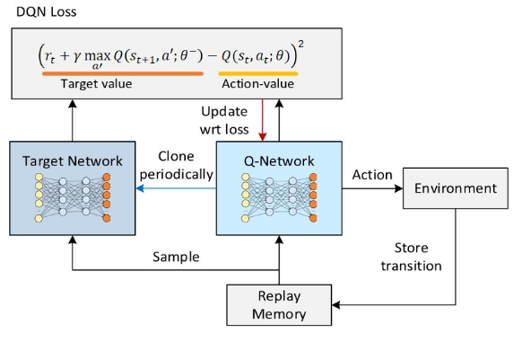

In [ ]:
def DQN():
    env = GridWorld()
    q = Qnet()
    q_target = Qnet()
    memory = ReplayBuffer()

    print_interval = 100
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.1, 0.3 - 0.01 * (n_epi / 200))
        done = False

        s = np.asarray(env.reset())
        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            (x_prime, y_prime), reward, done = env.step(a)
            s_prime =  np.array([x_prime, y_prime])
            done_mask = 0.0 if done else 1.0
            memory.put((s, a, reward, s_prime, done_mask))
            s = s_prime
            score += reward
            if done:
                break
        if memory.size() > 1000:
            train(q, q_target, memory, optimizer)

        if n_epi % print_interval == 0 and n_epi != 0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                n_epi, score / print_interval, memory.size(), epsilon * 100))
            score = 0.0

    # print policy
    for r in range(4):
        for c in range(4):
            s = np.array([c, r])
            a = q.max_action(torch.from_numpy(s).float())
            if c == 3 and r == 3:
                str = 'G'
            elif c == 0 and r == 3:
                str = 'H'
            elif c == 1 and r == 1:
                str = 'H'
            elif c == 3 and r == 1:
                str = 'H'
            elif c == 3 and r == 2:
                str = 'H'
            else:
                if a == 0:
                    str = '<'
                elif a == 1:
                    str = 'v'
                elif a == 2:
                    str = '>'
                elif a == 3:
                    str = '^'
            print('%03s  '%str, end='')
        print('')

# Main

In [ ]:
if __name__ == '__main__':
    DQN()